In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutil


import matplotlib.pyplot as plt
import numpy as np

import os

In [2]:
# 定义超参数
image_size = 28 #图像尺寸大小
input_dim = 100 #输入给生成器的向量维度，维度越大可以增加生成器输出样本的多样性
num_channels = 1 # 图像的通道数
num_features = 64 #生成器中间的卷积核数量

batch_size = 64 #批次大小

# 如果系统中存在着GPU，我们将用GPU来完成张量的计算
use_cuda = torch.cuda.is_available() #定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='./08_data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor，在加载数据的时候，就可以对图像做预处理
                            download=True) #当找不到文件的时候，自动下载

# 加载测试数据集
test_dataset = dsets.MNIST(root='./08_data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

'''我们希望将测试数据分成两部分，一部分作为校验数据，一部分作为测试数据。
校验数据用于检测模型是否过拟合，并调整参数，测试数据检验整个模型的工作'''


# 首先，我们定义下标数组indices，它相当于对所有test_dataset中数据的编码
# 然后定义下标indices_val来表示校验集数据的那些下标，indices_test表示测试集的下标
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

# 根据这些下标，构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据两个采样器来定义加载器，注意将sampler_val和sampler_test分别赋值给了validation_loader和test_loader
validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val
                                               )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          sampler = sampler_test
                                         )


## 一、生成器预测图像模型

在这个模型中，我们根据输入的手写数字生成一张图像，并让这个图像与数据中的样本图像尽可能一致

In [10]:
#生成器模型定义

class ModelG(nn.Module):
    def __init__(self):
        super(ModelG,self).__init__()
        self.model=nn.Sequential() #model为一个内嵌的序列化的神经网络模型
        
        # 利用add_module增加第一个反卷积层，输入为input_dim维，输出为2*num_features维，窗口大小为5，padding是0
        # 输入图像大小为1，输出图像大小为W'=(W-1)S-2P+K+P'=(1-1)*2-2*0+5+0=5, 5*5
        self.model.add_module('deconv1',nn.ConvTranspose2d(input_dim, num_features*2, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm1',nn.BatchNorm2d(num_features*2))
        # 增加非线性层
        self.model.add_module('relu1',nn.ReLU(True))
        
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口5，padding=0
        # 输入图像大小为5，输出图像大小为W'=(W-1)S-2P+K+P'=(5-1)*2-2*0+5+0=13, 13*13
        self.model.add_module('deconv2',nn.ConvTranspose2d(num_features*2, num_features, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm2',nn.BatchNorm2d(num_features))
        # 增加非线性层
        self.model.add_module('relu2',nn.ReLU(True))

        # 增加第三层反卷积层，输入num_features维，输出num_features维，窗口4，padding=0
        # 输入图像大小为13，输出图像大小为W'=(W-1)S-2P+K+P'=(13-1)*2-2*0+4+0=28, 28*28
        self.model.add_module('deconv3',nn.ConvTranspose2d(num_features, num_channels, 4, 2, 0,bias=False))
        #self.model.add_module('tanh',nn.Tanh())
        self.model.add_module('sigmoid',nn.Sigmoid())
        
    def forward(self,input):
        output = input
        
        #遍历网络的所有层，一层层输出信息
        for name, module in self.model.named_children():
            output = module(output)
        #输出一张28*28的图像
        return(output)


def weight_init(m):
    #模型参数初始化．
    #默认的初始化参数卷积核的权重是均值大概为0，方差在10^{-2}. BatchNorm层的权重均值是大约0.5，方差在0.2左右
    #使用如下初始化方式可以，可以让方差更小，使得收敛更快
    class_name=m.__class__.__name__
    if class_name.find('conv')!=-1:
        m.weight.data.normal_(0, 0.02)
    if class_name.find('norm')!=-1:
        m.weight.data.normal_(1.0, 0.02)
        
def make_show(img):
    # 将张量变成可以显示的图像
    img = img.data.expand(batch_size, 3, image_size, image_size)
    return img

def imshow(inp, title=None):
    # 在屏幕上绘制图像
    """Imshow for Tensor."""
    if inp.size()[0] > 1:
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        inp = inp[0].numpy()
    mvalue = np.amin(inp)
    maxvalue = np.amax(inp)
    if maxvalue > mvalue:
        inp = (inp - mvalue)/(maxvalue - mvalue)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [ ]:
#训练模型

print('Initialized!')

#定义生成器模型
net = ModelG()
net = net.cuda() if use_cuda else net

#目标函数采用最小均方误差
criterion = nn.MSELoss()
#定义优化器
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

# 随机选择生成0-9的数字，用于每个周期打印查看结果用
samples = np.random.choice(10, batch_size) # 抽样 batch_size 个 在范围[0, 10)之间的数
samples = torch.from_numpy(samples).type(dtype)

#开始训练
step = 0 #计数经历了多少时间步
num_epochs = 20 #总的训练周期
record = []
for epoch in range(num_epochs):
    train_loss = []
    
    # 加载数据批次
    for batch_idx, (data, target) in enumerate(train_loader):
        # 注意数据中的data转化为了要预测的target，数据中的target则转化成了输入给网络的标签
        target, data = data.clone().detach().requires_grad_(True), target.clone().detach() #data为一批图像，target为一批标签
        # 将数据加载到GPU中
        if use_cuda:
            target, data = target.cuda(), data.cuda()
            
        #将输入的数字标签转化为生成器net能够接受的(batch_size, input_dim, 1, 1)维张量
        data = data.type(dtype)
        data.resize_(data.size()[0], 1, 1, 1)
        data = data.expand(data.size()[0], input_dim, 1, 1)

        net.train() # 给网络模型做标记，标志说模型正在训练集上训练，
                    #这种区分主要是为了打开关闭net的training标志
        output = net(data) #神经网络完成一次前馈的计算过程，得到预测输出output
        loss = criterion(output, target) #将output与标签target比较，计算误差， 默认计算误差的平均值
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降算法
        step += 1
        # 记载损失函数值
        if use_cuda:
            loss = loss.cpu()
        train_loss.append(loss.data.numpy())
        
        
        if step % 100 == 0: #每间隔100个batch执行一次打印等操作    
            net.eval() # 给网络模型做标记，标志说模型在校验集上运行
            val_loss = [] #记录校验数据集准确率的容器
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            idx = 0
            for (data, target) in validation_loader:
                target, data = data.clone().detach().requires_grad_(True), target.clone().detach()
                idx += 1
                if use_cuda:
                    target, data = target.cuda(), data.cuda()
                data = data.type(dtype)
                data.resize_(data.size()[0], 1, 1, 1)
                data = data.expand(data.size()[0], input_dim, 1, 1)
                output = net(data) #完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                loss = criterion(output, target) #将output与标签target比较，计算误差
                if use_cuda:
                    loss = loss.cpu()
                val_loss.append(loss.data.numpy())
                #打印误差等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print('训练周期: {} [{}/{} ({:.0f}%)]\t训练数据Loss: {:.6f}\t校验数据Loss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(train_loss), np.mean(val_loss)))
            record.append([np.mean(train_loss), np.mean(val_loss)])
        
    
    # 产生一组图像保存到temp1文件夹下（需要事先建立好该文件夹），检测生成器当前的效果
    # 改变输入数字的尺寸，适应于生成器网络
    with torch.no_grad():
        samples.resize_(batch_size,1,1,1)
    samples = samples.data.expand(batch_size, input_dim, 1, 1)
    samples = samples.cuda() if use_cuda else samples #加载到GPU
    fake_u = net(samples) #用原始网络作为输入，得到伪造的图像数据
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u) #将张量转化成可绘制的图像
    os.makedirs('08_data/temp1', exist_ok=True)
    vutil.save_image(img,'08_data/temp1/fake%s.png'% (epoch)) #保存生成的图像

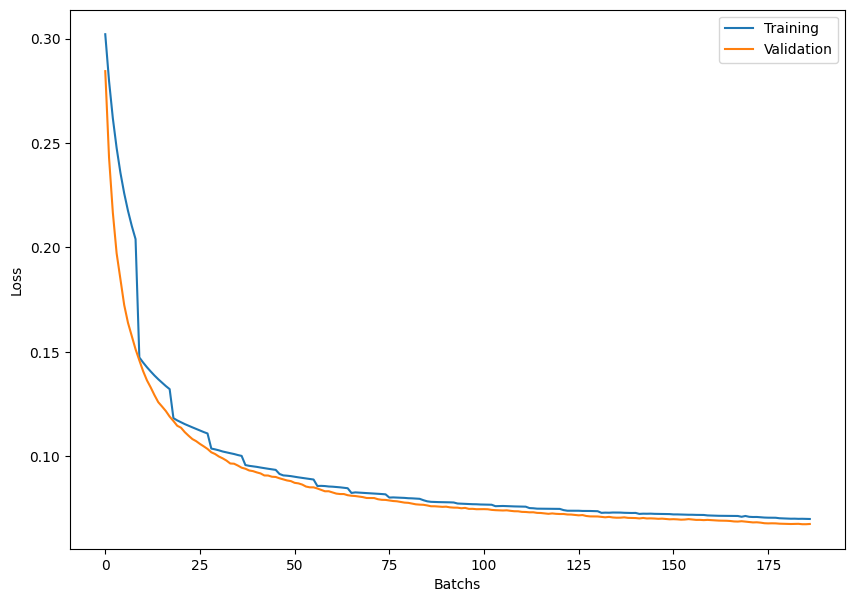

In [12]:
plt.figure(figsize = (10, 7))
plt.plot([i[0] for i in record], label='Training')
plt.plot([i[1] for i in record], label='Validation')
plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.legend()

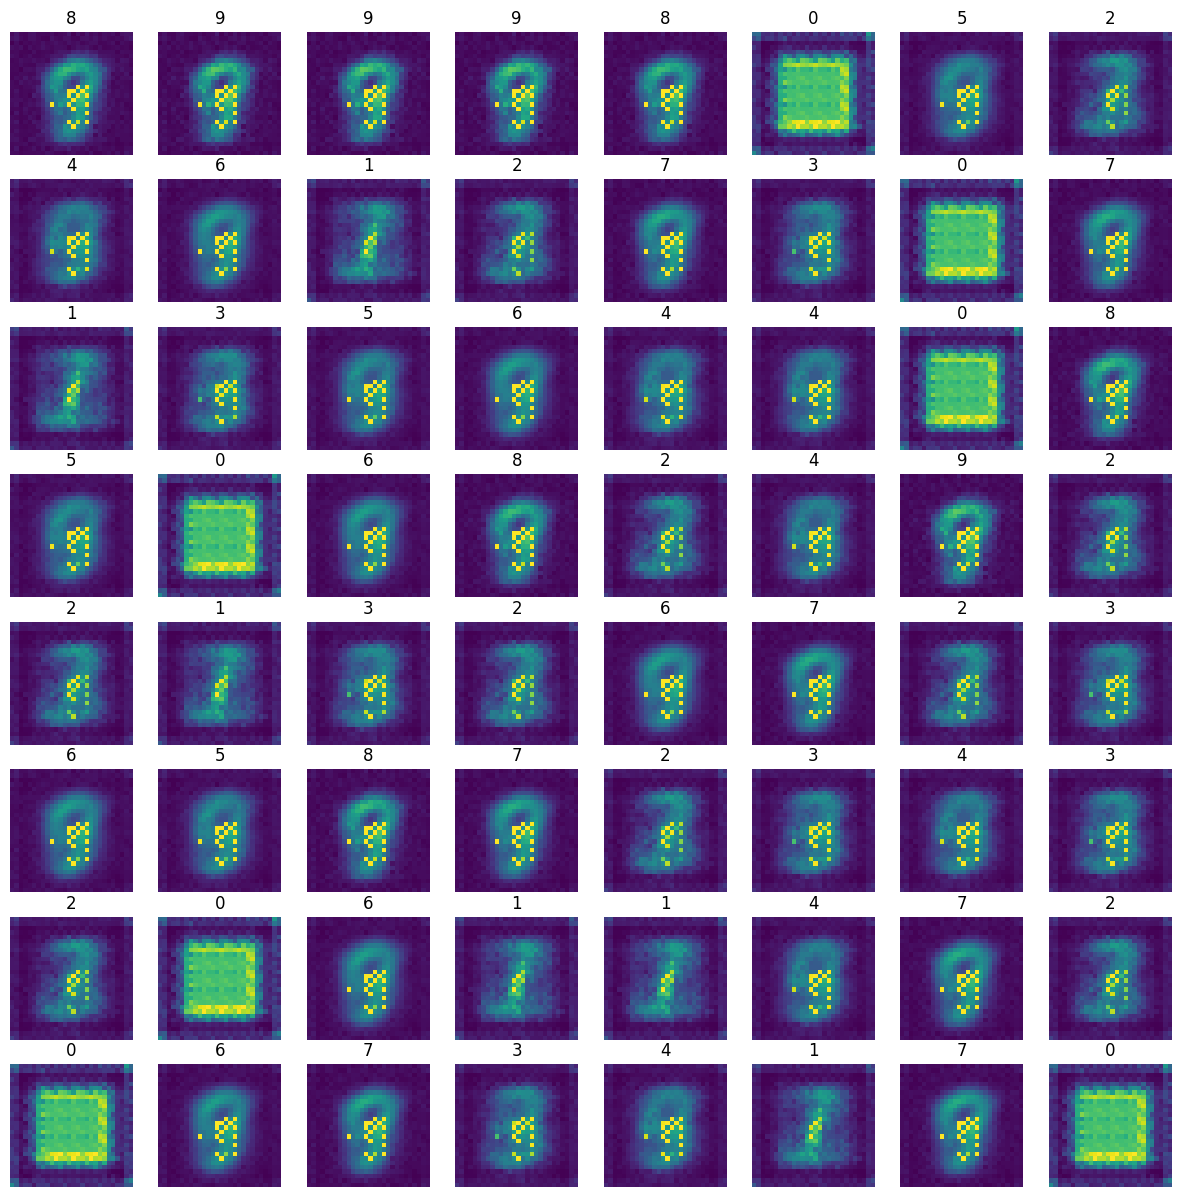

In [13]:
# 绘制一批图像样本
fake_u = fake_u.cpu() if use_cuda else fake_u
samples = samples.cpu() if use_cuda else samples
img = fake_u.data #将张量转化成可绘制的图像
fig = plt.figure(figsize = (15, 15))

for i in range(batch_size):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    imshow(img[i].data, samples.data.numpy()[i][0,0,0].astype(int))

## 二、生成器 － 识别器模型

在这个模型中，我们不改变生成器，但是改变了网络的目标函数。我们加入了一个识别器，它通过固定值的方式迁移自一个手写体识别器
然后让生成器生成图像，并让识别器进行识别，将识别的误差作为目标函数，调整生成器，从而能给出正确的分类标签

In [14]:
# 定义待迁移的网络框架，所有的神经网络模块包括：Conv2d、MaxPool2d，Linear等模块都不需要重新定义，会自动加载
# 但是网络的forward功能没有办法自动实现，需要重写。
# 一般的，加载网络只加载网络的属性，不加载方法
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x, dim = 1) #log_softmax可以理解为概率对数值
        return x
    def retrieve_features(self, x):
        #该函数专门用于提取卷积神经网络的特征图的功能，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) #完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层pooling
        feature_map2 = F.relu(self.conv2(x)) #第二层卷积，两层特征图都存储到了feature_map1, feature_map2中
        return (feature_map1, feature_map2)
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素


In [17]:
netR = torch.load('05_convolution_data/minst_conv_checkpoint', weights_only=False) #读取硬盘上的minst_conv_checkpoint文件
netR = netR.cuda() if use_cuda else netR #加载到GPU中
for para in netR.parameters():
    para.requires_grad = False #将识别器的权重设置为固定值